In [9]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input


In [10]:

# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)


#reading image
Root_train = "D:\semester 7\projectcv\Data\Product Recoginition\Training Data"
Root_test = "D:\semester 7\projectcv\Data\Product Recoginition\Validation Data"

def read_image(ROOT,index):
  
    filename = "web" + index[1].split('.')[0] + ".png"  # Construct the new filename
    
    path = os.path.join(ROOT, index[0], filename)
    try: 
        image = cv2.imread(path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))  # Reshape the image to a consistent size
            return image
        else:
            print(f"Unable to read image: {path}")
            return None
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        return None
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #return image

#read data train and test
def read_dataset(directory_train,directory_test):
    folders_train = os.listdir(directory_train)
    folders_test = os.listdir(directory_test)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders_train:
        num_files = len(os.listdir(os.path.join(directory_train, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders_test:
        num_files = len(os.listdir(os.path.join(directory_test, folder)))
        test_list[folder] = num_files

    return train_list, test_list


train_list, test_list = read_dataset(Root_train,Root_test)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTrain List:", train_list)
print("\nTest List:", test_list)
# create triplet (anchor, positive ,negative )

Length of training list: 40
Length of testing list : 20

Train List: {'1': 14, '10': 9, '11': 9, '12': 9, '13': 8, '14': 8, '15': 8, '16': 8, '17': 8, '18': 8, '19': 7, '2': 10, '20': 7, '21': 7, '22': 7, '23': 7, '24': 7, '25': 7, '26': 7, '27': 7, '28': 7, '29': 7, '3': 10, '30': 7, '31': 7, '32': 7, '33': 7, '34': 7, '35': 7, '36': 6, '37': 6, '38': 6, '39': 6, '4': 9, '40': 6, '5': 9, '6': 9, '7': 9, '8': 9, '9': 9}

Test List: {'41': 6, '42': 6, '43': 6, '44': 6, '45': 6, '46': 6, '47': 6, '48': 6, '49': 6, '50': 6, '51': 6, '52': 6, '53': 6, '54': 6, '55': 6, '56': 6, '57': 6, '58': 6, '59': 6, '60': 6}


In [11]:
#create triplet (anchor,positive ,negative)
def create_triplets(directory, folder_list):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))
        num_files = len(files)

        for i in range(1,num_files - 1):
            for j in range(i + 1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(1, folder_list[neg_folder] - 1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

train_triplet = create_triplets(Root_train, train_list)
test_triplet  = create_triplets(Root_test, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))
print("\nExamples of triplets:")
for i in range(len(train_triplet)):
    print(train_triplet[i])



Number of training triplets: 833
Number of testing triplets : 200

Examples of triplets:
(('36', '1.jpg'), ('36', '2.jpg'), ('19', '5.jpg'))
(('31', '2.jpg'), ('31', '3.jpg'), ('24', '5.jpg'))
(('11', '2.jpg'), ('11', '5.jpg'), ('5', '5.jpg'))
(('12', '1.jpg'), ('12', '3.jpg'), ('16', '6.jpg'))
(('17', '1.jpg'), ('17', '6.jpg'), ('2', '3.jpg'))
(('8', '2.jpg'), ('8', '7.jpg'), ('23', '5.jpg'))
(('1', '3.jpg'), ('1', '8.jpg'), ('8', '1.jpg'))
(('17', '4.jpg'), ('17', '7.jpg'), ('22', '6.jpg'))
(('35', '1.jpg'), ('35', '2.jpg'), ('12', '1.jpg'))
(('9', '1.jpg'), ('9', '4.jpg'), ('10', '8.jpg'))
(('12', '3.jpg'), ('12', '8.jpg'), ('1', '7.jpg'))
(('34', '4.jpg'), ('34', '6.jpg'), ('31', '2.jpg'))
(('25', '1.jpg'), ('25', '6.jpg'), ('5', '6.jpg'))
(('27', '4.jpg'), ('27', '6.jpg'), ('4', '2.jpg'))
(('10', '3.jpg'), ('10', '4.jpg'), ('3', '1.jpg'))
(('20', '3.jpg'), ('20', '5.jpg'), ('27', '6.jpg'))
(('3', '5.jpg'), ('3', '7.jpg'), ('16', '5.jpg'))
(('5', '3.jpg'), ('5', '5.jpg'), ('11', '2

In [12]:

#batches
def get_batch(triplet_list, batch_size=256, preprocess=True,dir=Root_train):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
       
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            
            anchor.append(read_image(dir,a))
            positive.append(read_image(dir,p))
            negative.append(read_image(dir,n))
            j+=1
        
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])


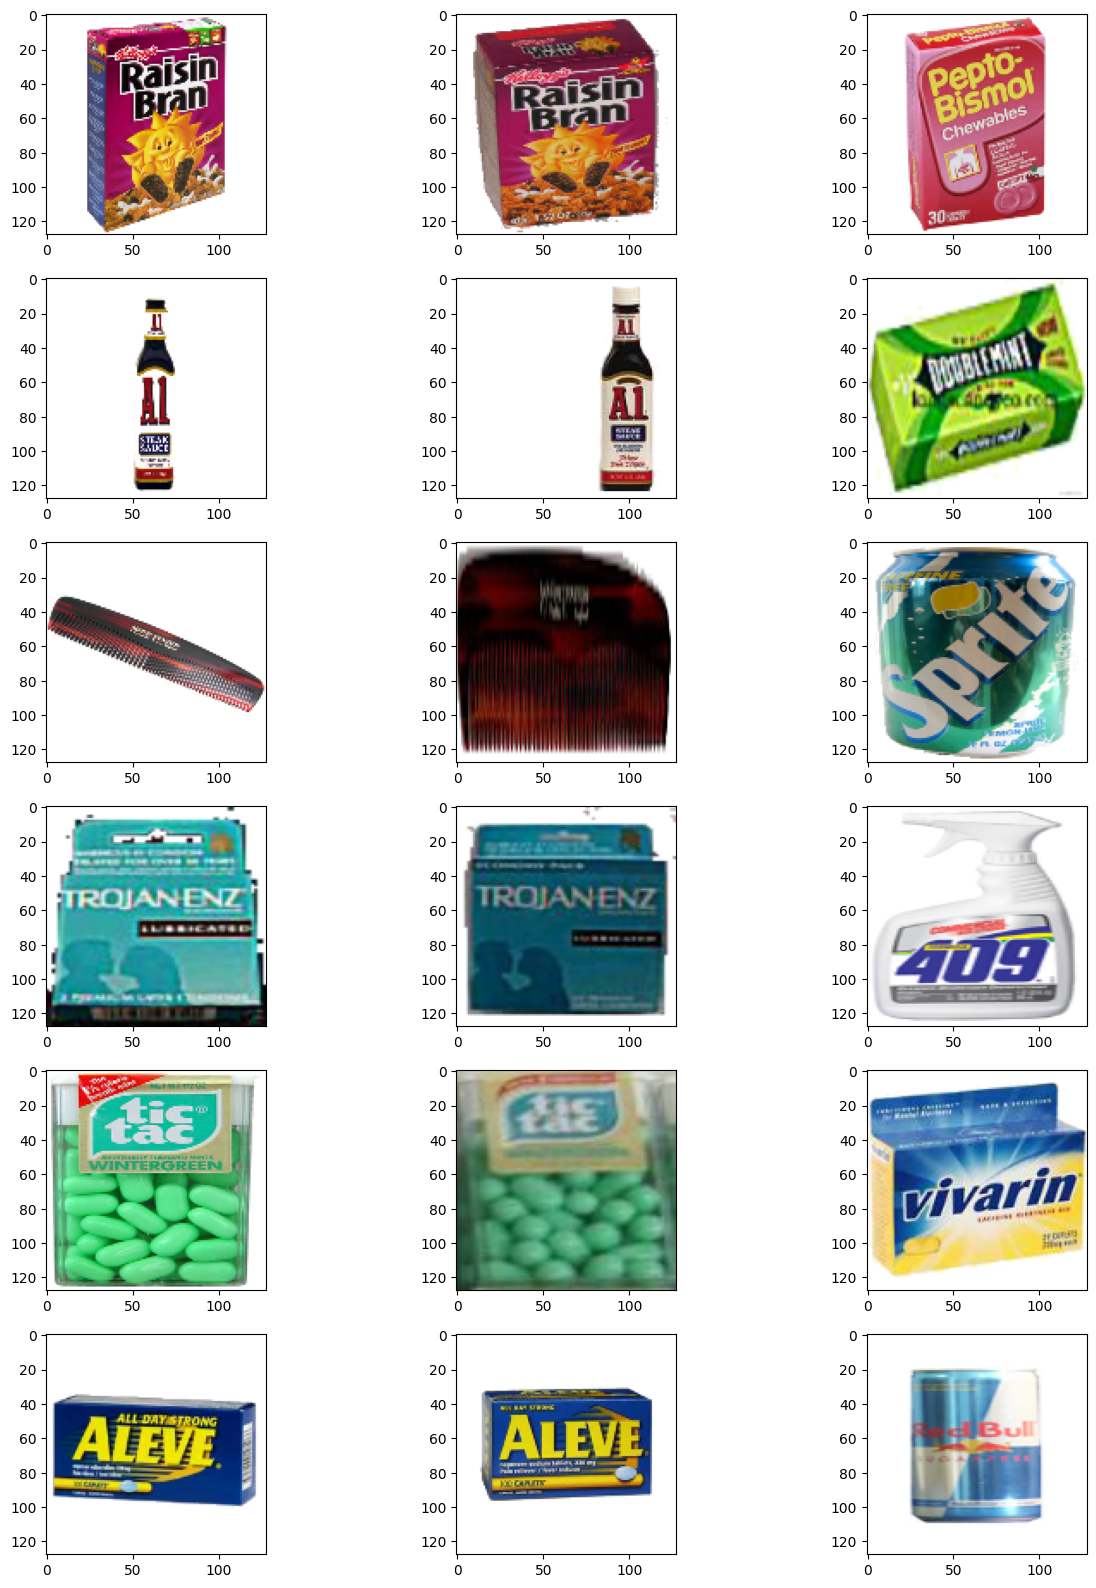

In [13]:
#ploting data
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False,dir=Root_train):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break


In [14]:
#create model 
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [15]:
from tensorflow.keras.applications import MobileNet

from tensorflow.keras import regularizers

def get_encoder(input_shape, l2_regularization=0.01):
    """ Returns the image encoding model using MobileNet """
    pretrained_model = MobileNet(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for layer in pretrained_model.layers[:-27]:
        layer.trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    
    return encode_model

In [16]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        #working to dimantion of vector 
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

In [17]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [19]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-4, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)


In [20]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size,dir=Root_test):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [21]:
save_all = False
epochs = 30
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        
        
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 30 sec)
Loss on train    = 0.62301
3/3 [==============================] - 2s 230ms/step
Accuracy on test = 0.95500

EPOCH: 2 	 (Epoch done in 21 sec)
Loss on train    = 0.37098
3/3 [==============================] - 1s 227ms/step
Accuracy on test = 0.94000

EPOCH: 3 	 (Epoch done in 23 sec)
Loss on train    = 0.24623
3/3 [==============================] - 1s 270ms/step
Accuracy on test = 0.95000

EPOCH: 4 	 (Epoch done in 22 sec)
Loss on train    = 0.16958
3/3 [==============================] - 1s 240ms/step
Accuracy on test = 0.95500

EPOCH: 5 	 (Epoch done in 21 sec)
Loss on train    = 0.11785
3/3 [==============================] - 1s 253ms/step
Accuracy on test = 0.95500

EPOCH: 6 	 (Epoch done in 21 sec)
Loss on train    = 0.08346
3/3 [==============================] - 1s 245ms/step
Accuracy on test = 0.96500

EPOCH: 7 	 (Epoch done in 21 sec)
Loss on train    = 0.06000
3/3 [==============================] - 1s 267ms/step
Accuracy on test = 0.95500

EPOCH

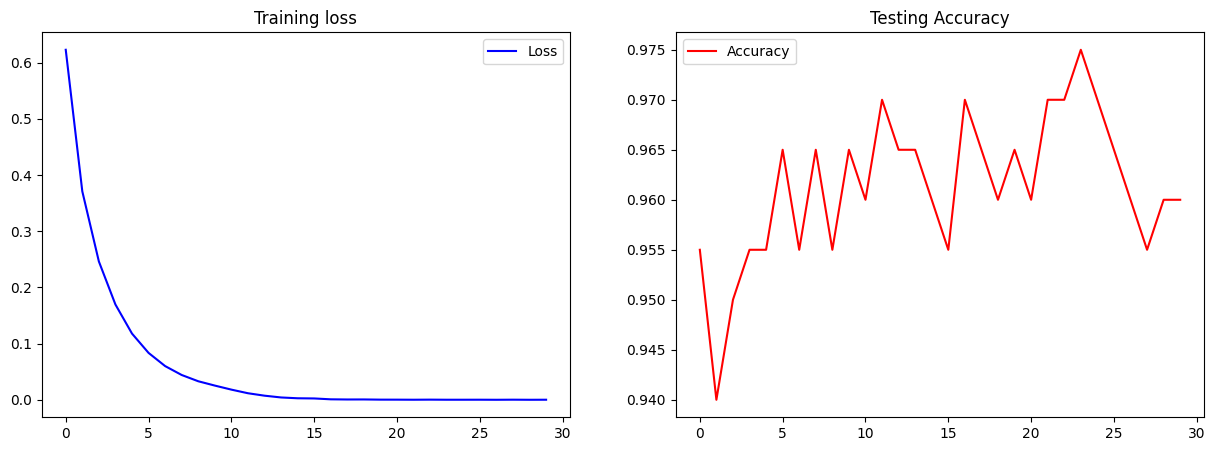

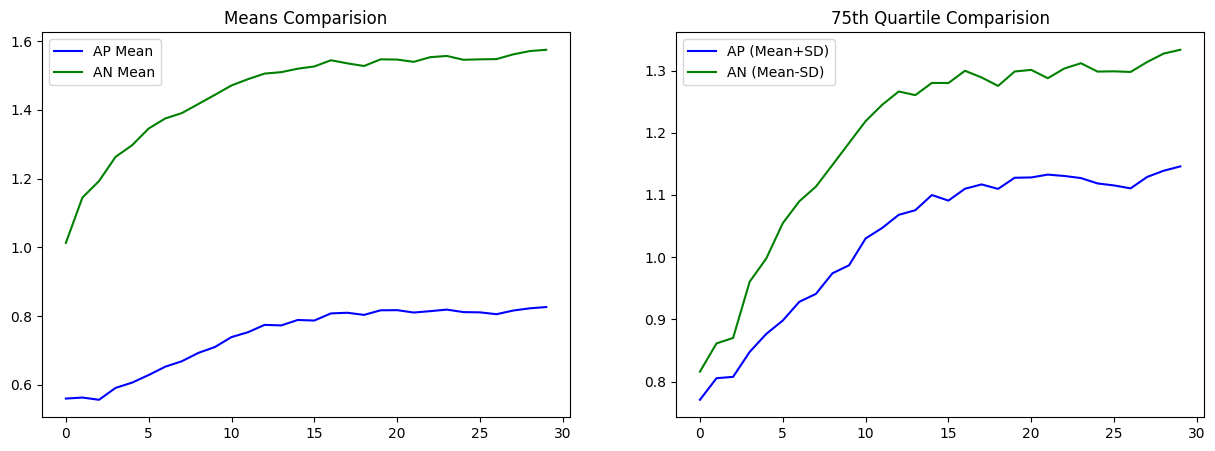

In [22]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [23]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)              

In [24]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

7/7 [==============================] - 1s 142ms/step

Accuracy of model: 0.88



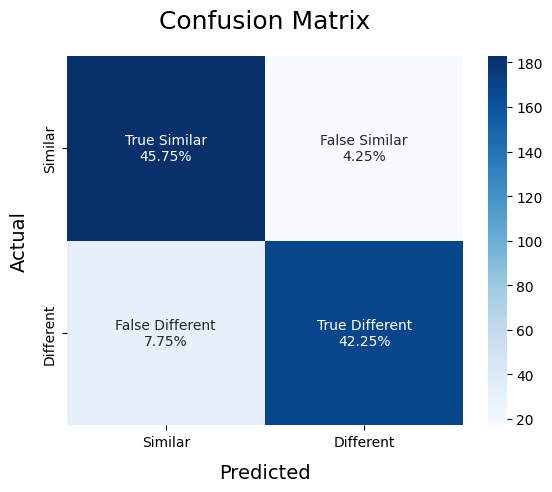

In [25]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256,dir=Root_test):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)